## Vinyard vs. not vinyard
This is a binary classification model that predicts whether a pixel in an image belongs to a vinyard or not. The samples and imagery data have been cleaned for modeling in earlier pre processing steps. This involved:
1. reducing the spatial extent (which reduced the number of sample pixels) to save on processing time 
2. using multi-spectral imagery to calculate vegetation indices which created more relevant features while also reducing complexity.
3. Calculating the mean and std of each vegetation index across 1 year of satellite imagery which also reduced feature complexity.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [90]:
samples = gpd.read_file('/Users/AuerPower/Metis/git/crop-classification/data/intermediate/samples_subset.shp')
samples.rename(columns={'layer': 'crop',
                        'gndvi_1': 'gndvi_mean', 'gndvi_2': 'gndvi_std', 
                        'msi_1': 'msi_mean', 'msi_2': 'msi_std', 
                        'ndii_1': 'ndii_mean', 'ndii_2': 'ndii_std',
                        'ndvi_1': 'ndvi_mean', 'ndvi_2': 'ndvi_std', 
                        'nrde_1': 'nrde_mean', 'nrde_2': 'nrde_std',
                        're_1': 're_mean', 're_2': 're_std'
                         }, inplace=True)

In [91]:
# Load Field ID data
regions = gpd.read_file('/Users/AuerPower/Metis/git/crop-classification/data/intermediate/fieldID_subset.shp')
regions.rename(columns={'layer': 'field'}, inplace=True)
regions.head()

,field,geometry
0,2690.0,POINT (575125.000 6833885.000)
1,2690.0,POINT (575135.000 6833885.000)
2,2691.0,POINT (575155.000 6833885.000)
3,2691.0,POINT (575165.000 6833885.000)
4,2691.0,POINT (575175.000 6833885.000)


In [92]:
samples = samples.merge(regions, how='left')
samples['field'] = [int(x) for x in samples['field']]
samples.head()

,crop,gndvi_mean,gndvi_std,msi_mean,msi_std,ndii_mean,ndii_std,ndvi_mean,ndvi_std,nrde_mean,nrde_std,re_mean,re_std,geometry,field
0,8.0,0.384528,0.115246,0.858284,0.143714,2.621973,5.340990,0.358772,0.182492,0.333323,0.090502,0.562390,0.109928,POINT (575125.000 6833885.000),2690
1,8.0,0.403404,0.083709,0.858284,0.143714,2.621973,5.340990,0.387312,0.124748,0.333323,0.090502,0.562390,0.109928,POINT (575135.000 6833885.000),2690
2,4.0,0.512671,0.080293,0.686751,0.155244,0.195134,0.102591,0.550536,0.139805,0.444923,0.085954,0.427002,0.103163,POINT (575155.000 6833885.000),2691
3,4.0,0.530932,0.085214,0.627883,0.225130,1.179418,2.848550,0.580122,0.143676,0.493996,0.114301,0.378424,0.127256,POINT (575165.000 6833885.000),2691
4,4.0,0.542835,0.084822,0.627883,0.225130,1.179418,2.848550,0.592570,0.142655,0.493996,0.114301,0.378424,0.127256,POINT (575175.000 6833885.000),2691


In [66]:
# Remove intercrop class
#samples = samples[samples.crop != 9]

In [93]:
# Assign binary classifier for vinyard/not vinyard
samples['vinyard'] = samples['crop'].replace([1, 2, 3, 4, 5, 6, 7, 9], 0)
samples['vinyard'] = samples['vinyard'].replace(8, 1)
samples['vinyard'].unique()

array([1., 0.])

In [94]:
# Reduce number of rows by 70% to decrease runtime
#samples = samples.sample(frac = 0.2)
samples.shape

(84564, 16)

In [69]:
samples.head()

,crop,gndvi_mean,gndvi_std,msi_mean,msi_std,ndii_mean,ndii_std,ndvi_mean,ndvi_std,nrde_mean,nrde_std,re_mean,re_std,geometry,field,vinyard
0,8.0,0.384528,0.115246,0.858284,0.143714,2.621973,5.340990,0.358772,0.182492,0.333323,0.090502,0.562390,0.109928,POINT (575125.000 6833885.000),2690,1.0
1,8.0,0.403404,0.083709,0.858284,0.143714,2.621973,5.340990,0.387312,0.124748,0.333323,0.090502,0.562390,0.109928,POINT (575135.000 6833885.000),2690,1.0
2,4.0,0.512671,0.080293,0.686751,0.155244,0.195134,0.102591,0.550536,0.139805,0.444923,0.085954,0.427002,0.103163,POINT (575155.000 6833885.000),2691,0.0
3,4.0,0.530932,0.085214,0.627883,0.225130,1.179418,2.848550,0.580122,0.143676,0.493996,0.114301,0.378424,0.127256,POINT (575165.000 6833885.000),2691,0.0
4,4.0,0.542835,0.084822,0.627883,0.225130,1.179418,2.848550,0.592570,0.142655,0.493996,0.114301,0.378424,0.127256,POINT (575175.000 6833885.000),2691,0.0


## Set up data for modeling

In [84]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn.model_selection import GroupShuffleSplit, StratifiedKFold, cross_val_score, train_test_split, GridSearchCV
from sklearn import linear_model, svm, naive_bayes, neighbors, ensemble
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score, auc, roc_curve, roc_auc_score, plot_roc_curve
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [95]:
# Function to split testing and training data
def get_field_split_data(df, test_size=.2, seed=42):
    '''This function splits the data by field ID to maintain spatial independence of train and test. 
    If we use points within the same field for training and testing we would basically 
    be testing our model with training points
    '''
    rs = np.random.RandomState(seed)
    
    total_fields = samples['field'].unique() 
    test_fields = rs.choice(total_fields, 
                           size=int(total_fields.shape[0] * test_size), 
                           replace=False)

    df_train = samples[~samples['field'].isin(test_fields)]
    df_test = samples[samples['field'].isin(test_fields)] 

    y_train, y_test = df_train['vinyard'], df_test['vinyard']
    X_train = df_train.drop(['field','geometry','crop', 'vinyard'],axis=1) 
    X_test = df_test.drop(['field','geometry','crop', 'vinyard'],axis=1)

    return X_train, X_test, y_train, y_test, df_train, df_test

In [96]:
# Split data
X_train, X_test, y_train, y_test, field_train, field_test = get_field_split_data(samples)

In [97]:
#dfmi.loc[:, ('one', 'second')]
field_train.loc[:,'split'] = 'train'
field_test.loc[:,'split'] = 'test'
train_test = field_train.append(field_test)
train_test.head()

/Users/AuerPower/opt/miniconda3/envs/metis/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/AuerPower/opt/miniconda3/envs/metis/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,crop,gndvi_mean,gndvi_std,msi_mean,msi_std,ndii_mean,ndii_std,ndvi_mean,ndvi_std,nrde_mean,nrde_std,re_mean,re_std,geometry,field,vinyard,split
2,4.0,0.512671,0.080293,0.686751,0.155244,0.195134,0.102591,0.550536,0.139805,0.444923,0.085954,0.427002,0.103163,POINT (575155.000 6833885.000),2691,0.0,train
3,4.0,0.530932,0.085214,0.627883,0.225130,1.179418,2.848550,0.580122,0.143676,0.493996,0.114301,0.378424,0.127256,POINT (575165.000 6833885.000),2691,0.0,train
4,4.0,0.542835,0.084822,0.627883,0.225130,1.179418,2.848550,0.592570,0.142655,0.493996,0.114301,0.378424,0.127256,POINT (575175.000 6833885.000),2691,0.0,train
5,4.0,0.547963,0.084809,0.594331,0.225558,1.206102,2.841755,0.601949,0.139470,0.515107,0.112529,0.358992,0.120293,POINT (575185.000 6833885.000),2691,0.0,train
6,4.0,0.556201,0.086872,0.594331,0.225558,1.206102,2.841755,0.612115,0.142207,0.515107,0.112529,0.358992,0.120293,POINT (575195.000 6833885.000),2691,0.0,train


In [61]:
# Plot training and test datasets
cropped_crop = gpd.read_file('/Users/AuerPower/Metis/git/crop-classification/data/intermediate/orange_river_crop_ext.shp')
prj = cropped_crop.crs
cropped_crop = cropped_crop.merge(train_test, how='left', left_on='Field_Id', right_on='field')
cropped_crop = cropped_crop.filter(['Field_Id','Crop_Id_Ne','geometry_x','vinyard', 'split'], axis=1)
cropped_crop = cropped_crop.rename({'geometry_x':'geometry'}, axis='columns')
cropped_crop = gpd.GeoDataFrame(cropped_crop, crs=prj, geometry='geometry')
cropped_crop.crs

{'init': 'epsg:32734'}

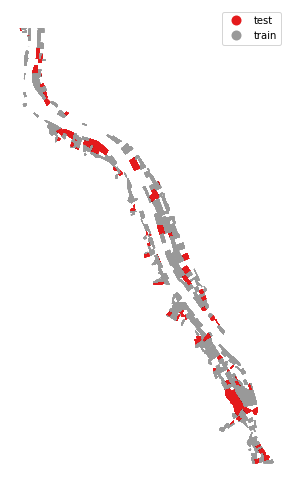

In [62]:
# Plot training and test datasets
cropped_crop = gpd.read_file('/Users/AuerPower/Metis/git/crop-classification/data/intermediate/orange_river_crop_ext.shp')
prj = cropped_crop.crs
cropped_crop = cropped_crop.merge(train_test, how='left', left_on='Field_Id', right_on='field')
cropped_crop = cropped_crop.filter(['Field_Id','Crop_Id_Ne','geometry_x','vinyard', 'split'], axis=1)
cropped_crop = cropped_crop.rename({'geometry_x':'geometry'}, axis='columns')
cropped_crop = gpd.GeoDataFrame(cropped_crop, crs=prj, geometry='geometry')
cropped_crop.to_file("/Users/AuerPower/Metis/git/crop-classification/data/intermediate/test_train_subset.shp")

cropped_crop.plot(column='split', figsize=(5, 10), cmap='Set1', legend=True)
plt.axis("off");

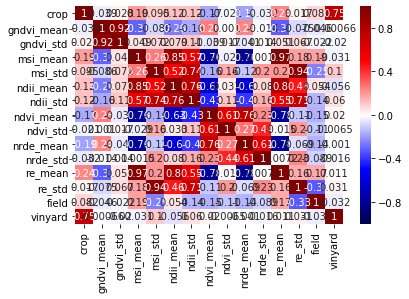

In [100]:
# scatter plot matrix
sns.heatmap(samples.sample(frac = 0.1).corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

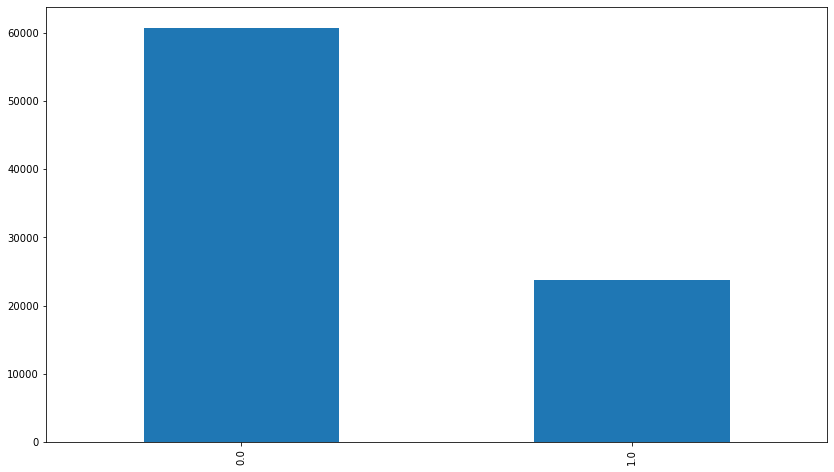

In [98]:
# Plot distribution of values
ax = samples['vinyard'].value_counts().plot(kind='bar', figsize=(14,8))

## Preliminary models

In [103]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
print("The score for kNN is")
print("Training: {:6.2f}%".format(100*knn.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*knn.score(X_test, y_test)))

The score for kNN is
Training:  97.12%
Test set:  80.99%


In [76]:
rf = ensemble.RandomForestClassifier(n_estimators=500)
rf.fit(X_train, y_train)
print("The score for rf is")
print("Training: {:6.2f}%".format(100*rf.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*rf.score(X_test, y_test)))

The score for rf is
Training: 100.00%
Test set:  87.00%


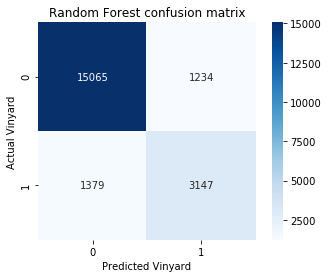

In [110]:
# # Print confusion matrix for random forests
rf_confusion = confusion_matrix(y_test, rf.predict(X_test))
# plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')
#            xticklabels=samples['crop'],
#            yticklabels=samples['crop'])

plt.xlabel('Predicted Vinyard')
plt.ylabel('Actual Vinyard')
plt.title('Random Forest confusion matrix');

To summarize the confusion matrix : 
- TRUE POSITIVES (TP)= 3147
- TRUE NEGATIVES (TN)= 15065
- FALSE POSITIVES (FP)= 1234
- FALSE NEGATIVES (FN)= 1379.

In [115]:
rf.predict(X_test)

array([0., 0., 1., ..., 0., 0., 0.])

ROC AUC score =  0.9120840609058997


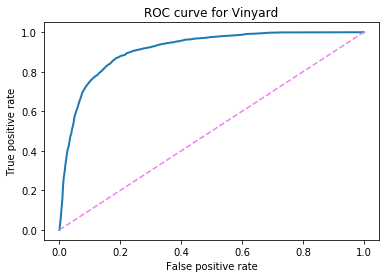

In [118]:
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Vinyard');
print("ROC AUC score = ", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

## Model Selection Using Grid Search
This took 4 hours to run

This was the output of the best model after grid search:

```SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
The mean F1 of the model is: 0.8960440901043053
```

In [120]:
# Create a pipeline
pipe = Pipeline([("classifier", RandomForestClassifier())])

# Create dictionary with candidate learning algorithms and their hyperparameters
search_space = [{"classifier": [LogisticRegression()],
                 "classifier__penalty": ['l2','l1'],
                 "classifier__C": np.logspace(0, 4, 10)
                 },
                {"classifier": [LogisticRegression()],
                 "classifier__penalty": ['l2'],
                 "classifier__C": np.logspace(0, 4, 10),
                 "classifier__solver":['newton-cg','saga','sag','liblinear'] ##This solvers don't allow L1 penalty
                 },
                {"classifier": [RandomForestClassifier()],
                 "classifier__n_estimators": [100, 120, 300, 500, 800, 1200],
                 "classifier__max_depth":[3,4,5,20,None],
                 "classifier__min_samples_leaf":[1,2,5,10,15,100],
                 "classifier__max_leaf_nodes": [2, 5,10]
                },
               {"classifier": [KNeighborsClassifier()],
                 "classifier__n_neighbors": [2,4,8,16],
                 },
                {"classifier": [svm.SVC()],
                 "classifier__C": [0.001, 0.01, 10, 100, 1000],
                 "classifier__class_weight":['Balanced', None]
#                  },
#                 "classifier":[GradientBoostingClassifier()], # was going to try this one but didn't have time
#                 "classifier__n_estimators": [100, 120, 300, 500, 800, 1200]
#                 'max_depth': [3, 4, 5, 25, 30]
                }]

In [121]:
# Create grid search 
gridsearch = GridSearchCV(pipe, search_space, cv=5, verbose=0, scoring='f1', n_jobs=-1)

# Fit grid search
best_model = gridsearch.fit(X_train, y_train)

In [123]:
# View best model results
print(best_model.best_estimator_.get_params()['classifier'])
print("The mean F1 of the model is:", best_model.score(X_train, y_train))

SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
The mean F1 of the model is: 0.8960440901043053


In [89]:
## Save the model for future use
import pickle

with open("/Users/AuerPower/Metis/git/crop-classification/outputs/Models/best_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

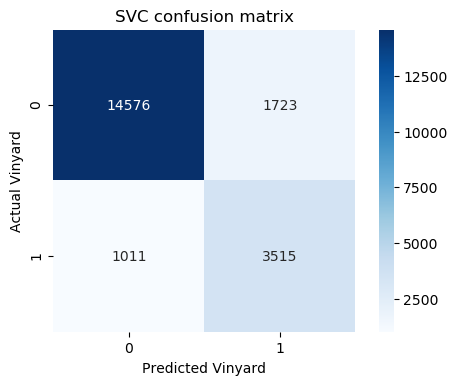

In [126]:
## Print confusion matrix for best model
confusion = confusion_matrix(y_test, best_model.predict(X_test))
plt.figure(dpi=100)
sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')
#           xticklabels=crop_names[''],
#            yticklabels=crop_names['crop'])

plt.xlabel('Predicted Vinyard')
plt.ylabel('Actual Vinyard')
plt.title('SVC confusion matrix');

In [99]:
#Predict target with best model parameters, except change probability to True so we can plot ROC
svc_model = svm.SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

best_model = svc_model.fit(X_train, y_train)

The F1 of the model is: 0.8695797868775551
ROC AUC score =  0.9254217520622784


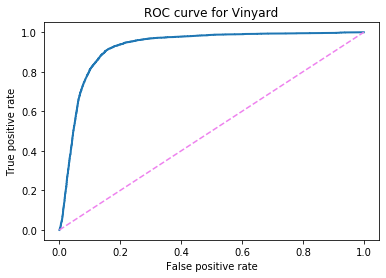

In [87]:
# Plot ROC for best model
fpr, tpr, thresholds = roc_curve(y_test, best_model.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Vinyard');
print("The of the model is:", best_model.score(X_test, y_test))
print("ROC AUC score = ", roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1]))

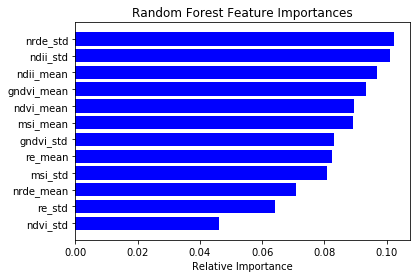

In [137]:
# Get variable importance with RF
rf_model.fit(X_train, y_train)
features = X_train.columns
importances = rf_model.feature_importances_
indices = np.argsort(importances)
plt.title('Random Forest Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Map errors

In [32]:
## Plot map of errors
final_prediction = best_model.predict(X_test)
final_prediction

array([0., 0., 1., ..., 0., 0., 0.])

In [54]:
# Join with samples to get geometry of predicted
prediction_df = X_test
prediction_df['predicted'] = final_prediction
prediction_df = prediction_df.drop(prediction_df.columns[0:12], axis=1)
prediction_df = prediction_df.merge(samples.drop(samples.columns[1:12], axis=1),
                                    how='left', left_index=True, right_index=True)
prediction_df.head()

,predicted,crop,re_std,geometry,field,vinyard
0,0.0,8.0,0.109928,POINT (575125.000 6833885.000),2690,1.0
1,0.0,8.0,0.109928,POINT (575135.000 6833885.000),2690,1.0
43,1.0,8.0,0.177512,POINT (575105.000 6833875.000),2690,1.0
44,1.0,8.0,0.177512,POINT (575115.000 6833875.000),2690,1.0
45,1.0,8.0,0.182633,POINT (575125.000 6833875.000),2690,1.0


In [55]:
## Calculate difference between predicted and vinyard to see where the errors are
## -1 is a false negative, 1 is a false positive, 0 is correctly predicted
prediction_df['error'] = prediction_df['predicted'] - prediction_df['vinyard']
prediction_df['error'] = prediction_df['error'].replace(0, 5)

In [56]:
# get crop names associated with ID and merge
crop_id = pd.read_csv('/Users/AuerPower/Metis/git/crop-classification/data/crop_id_list.csv')
crop_id = crop_id.rename(columns={'crop':'crop_name'})
prediction_df = prediction_df.merge(crop_id, how='left', left_on='crop', right_on='crop_id')
prediction_df['error_type'] = prediction_df['error'].replace([-1, 1, 5], ['FN','FP','correct'])
prediction_df.to_file('/Users/AuerPower/Metis/git/crop-classification/data/intermediate/error_with_crops.shp')
prediction_df.to_csv('/Users/AuerPower/Metis/git/crop-classification/data/intermediate/error_with_crops.csv')
prediction_df.head()

,predicted,crop,re_std,geometry,field,vinyard,error,crop_id,crop_name,error_type
0,0.0,8.0,0.109928,POINT (575125.000 6833885.000),2690,1.0,-1.0,8,Vineyard,FN
1,0.0,8.0,0.109928,POINT (575135.000 6833885.000),2690,1.0,-1.0,8,Vineyard,FN
2,1.0,8.0,0.177512,POINT (575105.000 6833875.000),2690,1.0,5.0,8,Vineyard,correct
3,1.0,8.0,0.177512,POINT (575115.000 6833875.000),2690,1.0,5.0,8,Vineyard,correct
4,1.0,8.0,0.182633,POINT (575125.000 6833875.000),2690,1.0,5.0,8,Vineyard,correct


In [101]:
# Save prediction raster
import rasterio as rio
from rasterio import features

rst = rio.open('/Users/AuerPower/Metis/git/crop-classification/data/intermediate/template_img_ras.tif')
meta = rst.meta.copy()
rst = rst.read()

out_fn = '/Users/AuerPower/Metis/git/crop-classification/data/intermediate/raster_results/rasterized_prediction.tiff'
with rio.open(out_fn, 'w+', **meta) as out:
    out_arr = out.read(1)

    # this is where we create a generator of geom, value pairs to use in rasterizing
    shapes = ((geom,value) for geom, value in zip(prediction_df.geometry, prediction_df.predicted))
    burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform)
    out.write_band(1, burned)

In [214]:
# Rasterize errors to see errors on a pixel by pixel basis
rst = rio.open('/Users/AuerPower/Metis/git/crop-classification/data/intermediate/template_img_ras.tif')
meta = rst.meta.copy()
rst = rst.read()

out_fn = '/Users/AuerPower/Metis/git/crop-classification/data/intermediate/raster_results/rasterized_error.tiff'
with rio.open(out_fn, 'w+', **meta) as out:
    out_arr = out.read(1)

    # this is where we create a generator of geom, value pairs to use in rasterizing
    shapes = ((geom,value) for geom, value in zip(prediction_df.geometry, prediction_df.error))
    burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform)
    out.write_band(1, burned)

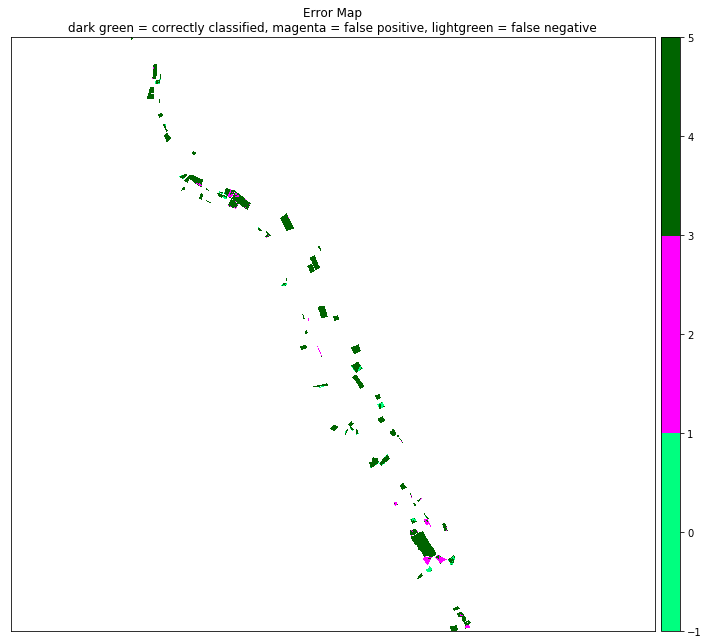

In [16]:
# Plot errors for test set
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
import earthpy.plot as ep

error_path = '/Users/AuerPower/Metis/git/crop-classification/data/intermediate/raster_results/rasterized_error.tiff'

with rio.open(error_path) as src:
    error_ras = src.read(1, masked=True)

#-1 is a false negative, 1 is a false positive, 0 is correctly predicted
cmap = ListedColormap(["springgreen","magenta", "darkgreen"])

ep.plot_bands(error_ras,
              cmap=cmap,
              title="Error Map\ndark green = correctly classified, magenta = false positive, lightgreen = false negative",
              scale=False)
plt.show()

It looks like the model is getting false positives on the 'intercrop' field type which I know (based on the metadata) is vinyards and pecans. So the model is actually correctly identifiying that there are vinyards in those intercrop fields eventhough they are being counted as false positives. I wonder how much my model will improve if I take the 'intercrop' class out of my dataset?